In [1]:
from scipy.spatial import cKDTree
import numpy as np
from scipy.spatial import distance_matrix
from sklearn.metrics import pairwise_distances
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [2]:
class dCrawler:
    def __init__(self,threshold=1.5): #just a placeholder value user need to the define at the call
        self.threshold = threshold
        self.centroids = None
        self.clusters = None 
        self.points = None #initialise the points to none ref at the start, fix the bug of points not being defined 
 
    def fit(self, points):
        self.points = points
        self.centroids, self.clusters = self._crawler(points)
        self.centroids, self.clusters = self._adjust_clusters(points)
        self.centroids, self.clusters = self._merge_clusters(points)
        self._cleanup_clusters()
        return self

    def predict(self, points):
        if self.centroids is None or self.clusters is None:
            raise ValueError("Model not fitted yet. Call 'fit' before 'predict'.")

        kdtree = cKDTree(self.centroids)
        _, labels = kdtree.query(points)
        return labels

    def _distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def _crawler(self, points):
        n = len(points)
        centroids = []
        clusters = []
        assigned = np.zeros(n, dtype=bool)

        i = 0
        while i < n:
            if not assigned[i]:
                centroid = points[i]
                cluster = [i]
                assigned[i] = True

                while True:
                    distances = np.sqrt(np.sum((points[~assigned] - centroid) ** 2, axis=1))
                    if len(distances) == 0:
                        break

                    closest_idx = np.argmin(distances)
                    closest_point = points[~assigned][closest_idx]

                    if distances[closest_idx] <= self.threshold:
                        cluster.append(np.where(~assigned)[0][closest_idx])
                        assigned[np.where(~assigned)[0][closest_idx]] = True
                        centroid = np.mean(points[cluster], axis=0)

                        distances = np.sqrt(np.sum((points[cluster] - centroid) ** 2, axis=1))
                        cluster = [c for c, d in zip(cluster, distances) if d <= self.threshold]
                        assigned[cluster] = True
                    else:
                        break

                centroids.append(centroid)
                clusters.append(cluster)

            i += 1

        return centroids, clusters

    def _adjust_clusters(self, points):
        n = len(points)
        assigned = np.zeros(n, dtype=bool)

        while True:
            kdtree = cKDTree(self.centroids)
            _, labels = kdtree.query(points)

            if np.all(assigned == labels):
                break

            assigned = labels

            for i in range(len(self.centroids)):
                cluster_points = points[labels == i]
                if len(cluster_points) > 0:
                    self.centroids[i] = np.mean(cluster_points, axis=0)

        self.clusters = [np.where(labels == i)[0] for i in range(len(self.centroids))]
        return self.centroids, self.clusters

    def _merge_clusters(self, points):
        cluster_thresh = self.threshold
        n_loop = 0

        while True:
            merged = False
            kdtree = cKDTree(self.centroids)
            distances, _ = kdtree.query(self.centroids, k=2)
            distances = distances[:, 1]

            merge_indices = np.where(distances <= cluster_thresh)[0]
            #Removed list - this needs to be added to account for the fact that if the cluster has already been merged then we skip it
            removed_list = []
            for i in merge_indices:
                #j = np.argmin(np.sqrt(np.sum((self.centroids - self.centroids[i]) ** 2, axis=1))) --> Here's the problem this should find the second one instead, because the minimum will be itself
                ds = np.sqrt(np.sum((self.centroids - self.centroids[i]) ** 2, axis=1)) # Get all the distances
                ds[i] = cluster_thresh #change it to the cluster thresh
                j = np.argmin(ds) #so now j should be different to i unless it is above the cluster_threshold

                if i != j:
                    if i not in removed_list:
                        self.centroids[i] = np.mean([self.centroids[i], self.centroids[j]], axis=0) #
                        #self.clusters[i].extend(self.clusters[j]) --> you can't extend a numpy array will concatenate instead
                        self.clusters[i] = np.concatenate((self.clusters[i], self.clusters[j]))
                        self.clusters[j] = []
                        merged = True
                        if len(self.clusters[i]) > 0: #check if the cluster is empty, fix the issue with the range of thresholds
                            cluster_indices = self.clusters[i].astype(int)
                            distances = np.sqrt(np.sum((points[cluster_indices] - self.centroids[i]) ** 2, axis=1))
                            self.clusters[i] = [c for c, d in zip(self.clusters[i], distances) if d <= self.threshold]
                        removed_list.append(j) #add j to the exclude list
            if not merged:
                break

            self.centroids = [c for c, cl in zip(self.centroids, self.clusters) if len(cl) > 0]
            self.clusters = [cl for cl in self.clusters if len(cl) > 0]

            unassigned_points = np.where(np.isin(np.arange(len(points)), np.concatenate(self.clusters), invert=True))[0]

            if len(unassigned_points) > 0:
                new_centroids, new_clusters = self._crawler(points[unassigned_points])
                self.centroids.extend(new_centroids)
                self.clusters.extend(new_clusters)
                n_loop += 1
            
            #Add in the adjust step
            self.centroids, self.clusters = self._adjust_clusters(points)
            
            if n_loop > 20:
                break

            cluster_thresh *= 0.95

        return self.centroids, self.clusters

    def _cleanup_clusters(self):
        cluster_ids = np.zeros(len(np.concatenate(self.clusters)), dtype=int)
        for i, cluster in enumerate(self.clusters):
            cluster_ids[cluster] = i + 1

        self.clusters = [np.where(cluster_ids == i)[0] for i in range(1, np.max(cluster_ids) + 1)] 
        self.centroids = [np.mean(self.points[cluster], axis=0) for cluster in self.clusters] #instance

In [4]:
df = pd.read_csv('../DemoData/demodata.csv')
data = df.to_numpy()[:,:2]
#points = data #some weird bug with the var name in the class fixedb-< properly referenced in the class
true_labels = df['Cluster'].to_numpy()

In [5]:
dcrawler = dCrawler(threshold=1.0)
dcrawler.centroids,dcrawler.clusters = dcrawler._crawler(data)
dcrawler.centroids,dcrawler.clusters = dcrawler._adjust_clusters(data)
dcrawler.centroids,dcrawler.clusters = dcrawler._merge_clusters(data)

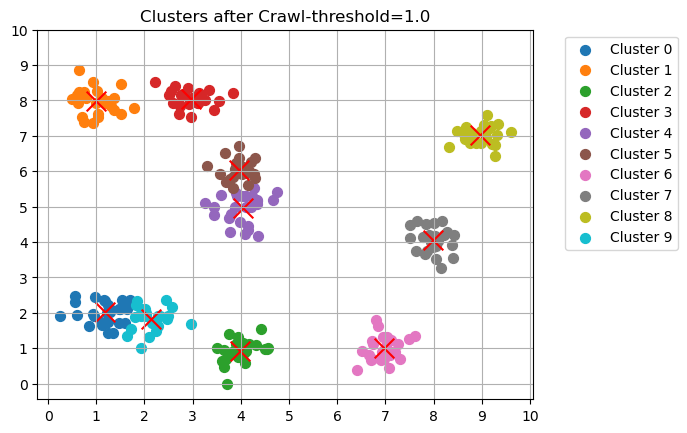

In [6]:
#Plot after crawl
for i, centroid in enumerate(dcrawler.centroids):
    idx = dcrawler.clusters[i]
    plt.scatter(data[idx, 0], data[idx, 1], s=50, label=f"Cluster {i}")
    
    #Finally the centroid positions
    plt.scatter(centroid[0], centroid[1], c='red', s=200, marker='x')

plt.grid()
plt.legend(bbox_to_anchor=(1.05,1))
plt.xticks([0,1,2,3,4,5,6,7,8,9,10])
plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
plt.title("Clusters after Crawl-threshold=1.0")
plt.show();

In [7]:
##trying on a range of thresholds
cls = []
cents = []
th_range = [0.1, 0.25, 0.3, 0.5, 0.75, 1, 2, 5, 10]
for th in th_range:
    dcrawler = dCrawler(threshold=th)
    dcrawler.fit(data)
    cls.append(dcrawler.clusters)
    cents.append(dcrawler.centroids)
    print(f"Threshold: {th}, Number of clusters: {len(dcrawler.centroids)}")

Threshold: 0.1, Number of clusters: 195
Threshold: 0.25, Number of clusters: 102
Threshold: 0.3, Number of clusters: 81
Threshold: 0.5, Number of clusters: 39
Threshold: 0.75, Number of clusters: 20
Threshold: 1, Number of clusters: 10
Threshold: 2, Number of clusters: 7
Threshold: 5, Number of clusters: 3
Threshold: 10, Number of clusters: 1


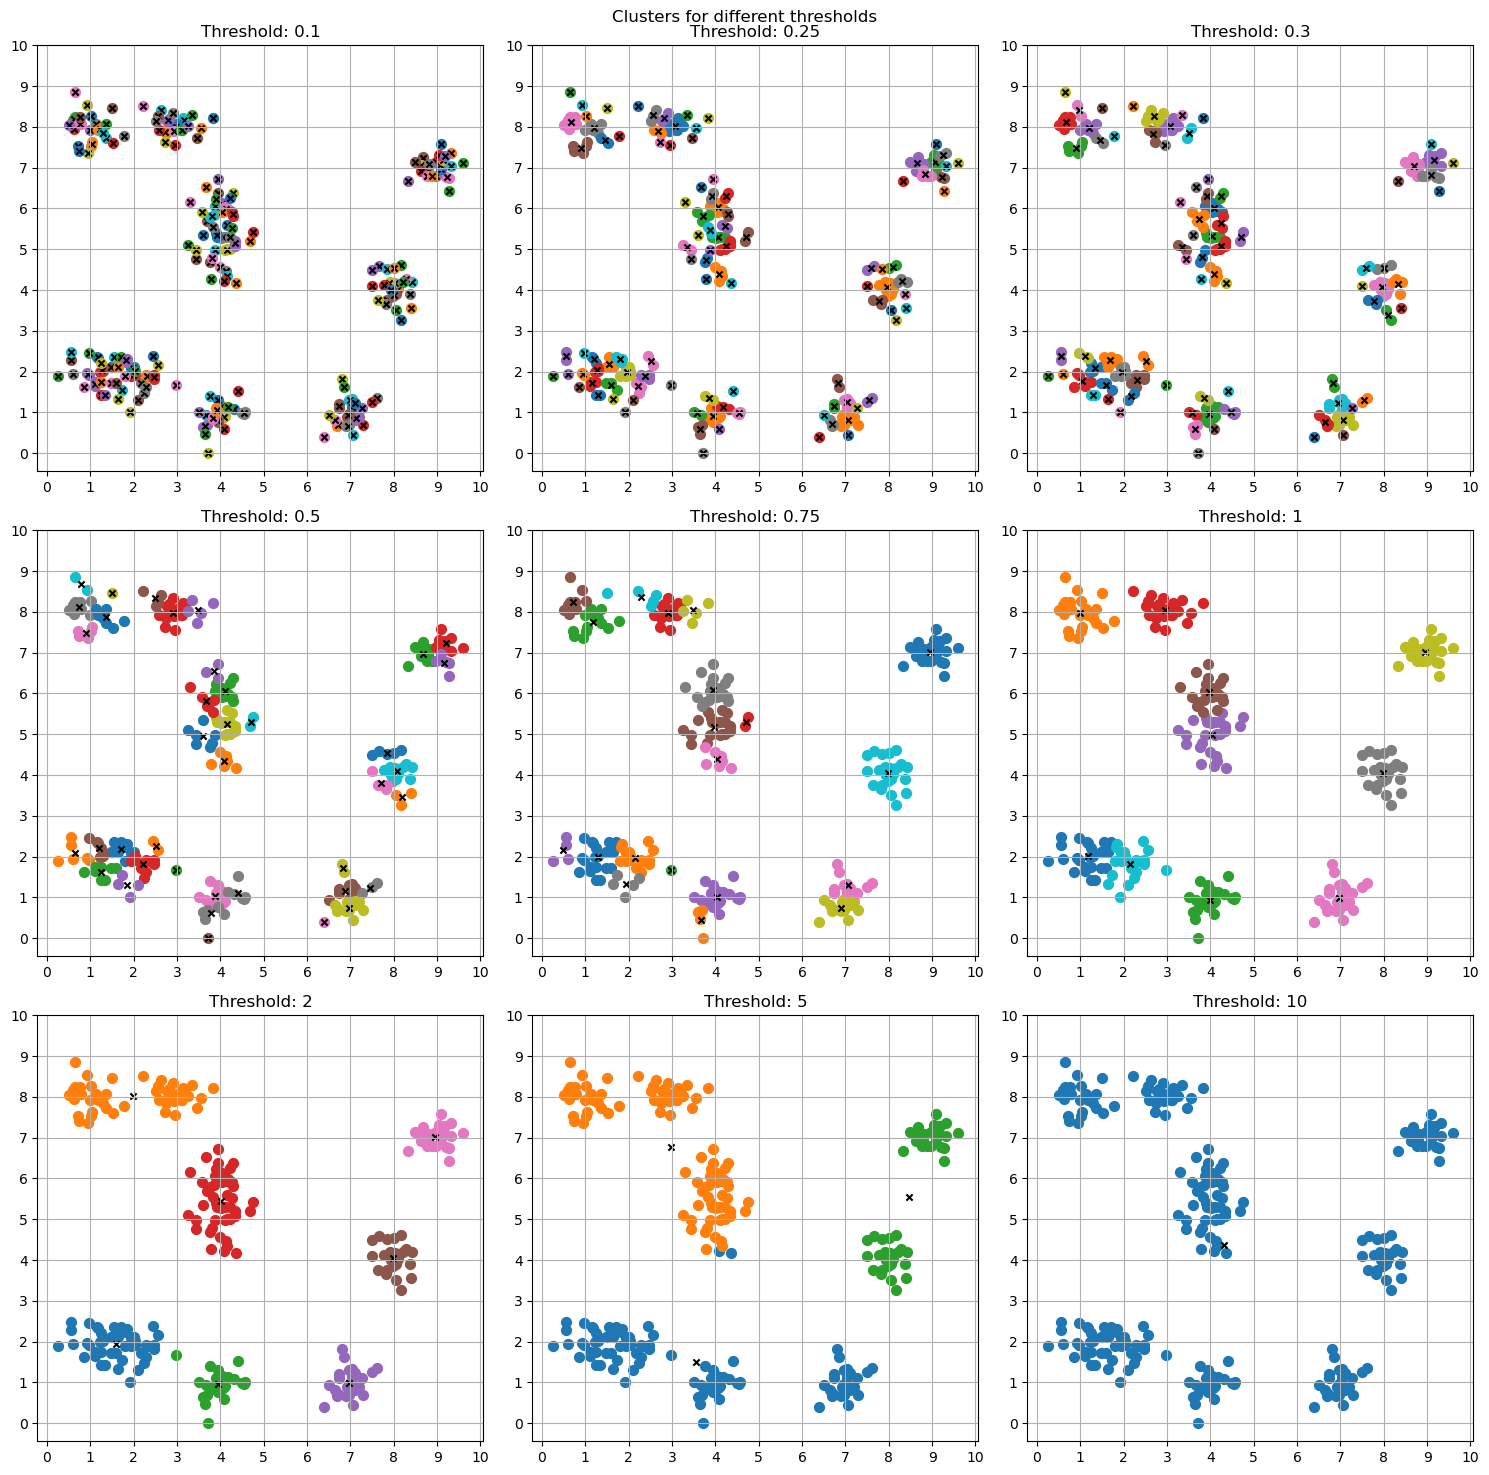

In [8]:
#plot for different thresholds
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Clusters for different thresholds")
for i, ax in enumerate(axs.flat):
    for j, centroid in enumerate(cents[i]):
        idx = cls[i][j]
        ax.scatter(data[idx, 0], data[idx, 1], s=50, label=f"Cluster {j}")
        ax.scatter(centroid[0], centroid[1], c='black', s=20, marker='x')
    ax.set_title(f"Threshold: {th_range[i]}")
    ax.grid()
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax.set_yticks([0,1,2,3,4,5,6,7,8,9,10])
plt.tight_layout()
plt.show();